In [190]:
import os
import glob
from skimage import io
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from _CONSTANTS.config import Config
import _CONSTANTS.conditions as conditions
import tools.file_io
from scipy.ndimage.measurements import center_of_mass

mouse = 'M232_ofc'
date = '05-30-2017'
reload = True

In [191]:
# load images
d = os.path.join('I:\IMPORTANT DATA\DATA_X', mouse, date)
start_time = time.time()
raw_dir = glob.glob(os.path.join(d, '*z'))
d_raw = glob.glob(os.path.join(raw_dir[0], '*.tif'))[0]
raw = io.imread(d_raw)
d_bg = os.path.join(d, 'bg.tif')
bg = io.imread(d_bg)
d_residual = os.path.join(d, 'res.tif')
residual = io.imread(d_residual)
d_denoised = os.path.join(d, 'den_bg.tif')
denoised = io.imread(d_denoised)
print('finished reading : {} s'.format(time.time() - start_time))

finished reading : 10.371841669082642 s


In [192]:
# load ROIs
data_directory = Config().LOCAL_DATA_PATH
data_path = os.path.join(data_directory, 'registration','CNMF', mouse, date)

if not reload:
    import matlab.engine
    eng = matlab.engine.start_matlab()
    ds = glob.glob(os.path.join('I:\IMPORTANT DATA\STORAGE_DATA', mouse + '_' + date + '*.mat'))
    assert len(ds) == 1
    temp = eng.load(ds[0])
    obj = list(temp.values())[0]
    obj_name = "obj"
    eng.workspace[obj_name] = obj
    signal = eng.eval(obj_name + ".roiCell('norm')")
    signal = np.asarray(signal).squeeze()
    roi = eng.eval(obj_name + ".roi")
    roi = np.asarray(roi).squeeze()
    roiT = roi.transpose(2, 0, 1)
    tools.file_io.save_numpy(data_path, 'roi', roiT)
    tools.file_io.save_numpy(data_path, 'signal', signal)
else:
    roiT = tools.file_io.load_numpy(os.path.join(data_path,'roi.npy'))
    signal = tools.file_io.load_numpy(os.path.join(data_path,'signal.npy'))
    print(roiT.shape)
    print(signal.shape)

(100, 260, 260)
(100, 5250)


In [208]:
# make ROI movies #0
roi_ixs = [2, 67, 97]
pad = 20
roi_movies = []
for r in roi_ixs:
    temporal = signal[r].reshape(-1,1)
    spatial = roiT[r].reshape(1,-1)
    out = np.matmul(temporal, spatial)
    outR = out.reshape(out.shape[0], roiT.shape[1], roiT.shape[2])

    comy, comx = np.round(center_of_mass(outR[0])).astype(int)
    outSmall = outR[:, comy - pad:comy + pad, comx - pad:comx + pad]
    roi_movies.append(outSmall)

# make ROI outlines
from scipy.ndimage.morphology import binary_erosion
roi_edges = []
roi_masks = []
for r in roi_ixs:
    t = roiT[r] > 0
    edge = t - binary_erosion(t)
    masked = np.ma.masked_where(edge == 0, edge)
    roi_edges.append(edge)
    roi_masks.append(masked)

# make ROI outlines
from scipy.ndimage.morphology import binary_erosion
roi_edges = []
roi_masks = []
for r in roi_ixs:
    t = roiT[r] > 0
    edge = t - binary_erosion(t)
    masked = np.ma.masked_where(edge == 0, edge)
    roi_edges.append(edge)
    roi_masks.append(masked)

#make ROI traces
traces_denoised = signal[np.array(roi_ixs)]
traces_noisy = []
for r in roi_ixs:
    trace_roi = np.multiply(raw, roiT[r])
    trace_noisy = np.mean(trace_roi, axis=(1, 2))
    traces_noisy.append(trace_noisy)

C:\Users\P\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\P\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
done


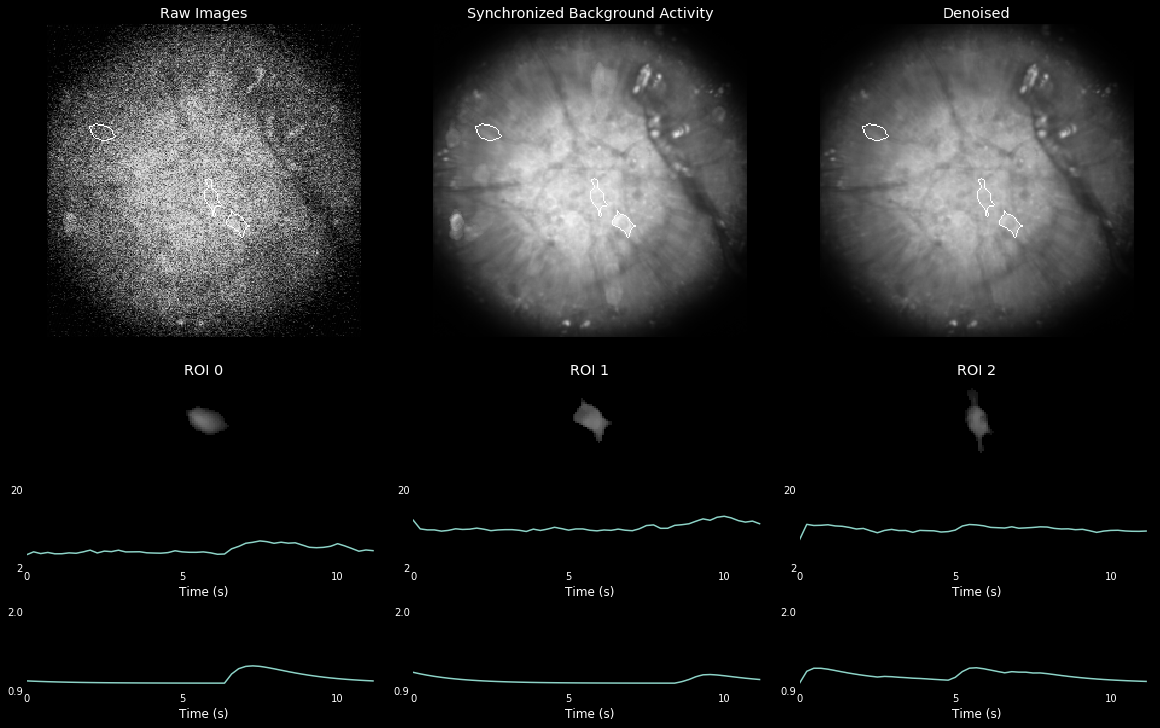

In [213]:
save_path = os.path.join(Config.LOCAL_FIGURE_PATH, 'MISC','CNMF')

end_frame = 200
ylim = [0.9, 2]
ylim1 = [2, 20]
window = 50
ani_frame(save_path, fps=30)
print('done')

In [212]:
def ani_frame(save_path, fps=30):
    def plot():
        plt.style.use('dark_background')
        widths = [1, 1, 1]
        heights = [4, 1, 1, 1]
        gs_kw = dict(width_ratios=widths, height_ratios=heights)
        fig, axs = plt.subplots(4, 3, figsize=(16, 10), constrained_layout=True,
                                gridspec_kw=gs_kw)

        stacks = [raw, bg, denoised]
        titles = ['Raw Images', 'Synchronized Background Activity', 'Denoised']
        ims = []
        for i in range(len(stacks)):
            ax = axs[0, i]
            curdata = stacks[i][0]
            min, max = np.min(curdata), np.max(curdata)
            im = ax.imshow(curdata, cmap='gray', vmax=max + 500)
            for mask in roi_masks:
                ax.imshow(mask, 'binary', interpolation=None, alpha=1)
            ax.axis('image')
            ax.axis('off')
            ax.set_title(titles[i])
            ims.append(im)

        roi_ims = []
        for i, roimovie in enumerate(roi_movies):
            ax = axs[1, i]
            im = ax.imshow(roimovie[0], cmap='gray', vmin=0, vmax=4)
            ax.axis('image')
            ax.axis('off')
            ax.set_title('ROI {}'.format(str(i)))
            roi_ims.append(im)

        def style_helper(ax, ylim):
            ax.grid(False)
            ax.tick_params(axis=u'both', which=u'both', length=0)
            ax.set_xlim([0, window])
            ax.set_ylim(ylim)
            ax.set_yticks(ylim)
            ax.set_xticks([0, 22, 44])
            ax.set_xticklabels([0, 5, 10])
            ax.set_xlabel('Time (s)')
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_visible(False)

        lines_noisy = []
        for i, trace in enumerate(traces_noisy):
            ax = axs[2, i]
            line, = ax.plot(trace[0])
            style_helper(ax, ylim1)
            lines_noisy.append(line)

        lines = []
        for i, trace in enumerate(traces_denoised):
            ax = axs[3, i]
            line, = ax.plot(trace[0])
            style_helper(ax, ylim)
            lines.append(line)

        return fig, ims, roi_ims, lines, lines_noisy

    def update_img(n):
        ims[0].set_data(raw[n])
        ims[1].set_data(denoised[n])
        ims[2].set_data(bg[n])
        for i, im in enumerate(roi_ims):
            im.set_data(roi_movies[i][n])

        for i, line in enumerate(lines):
            if n < window:
                x = np.arange(n)
                y = traces_denoised[i][:n]
            else:
                x = np.arange(window)
                y = traces_denoised[i][n - window:n]
            line.set_xdata(x)
            line.set_ydata(y)

        for i, line in enumerate(lines_noisy):
            if n < window:
                x = np.arange(n)
                y = traces_noisy[i][:n]
            else:
                x = np.arange(window)
                y = traces_noisy[i][n - window:n]
            line.set_xdata(x)
            line.set_ydata(y)
        if n % 10 == 0:
            print(n)
        # return ims, roi_ims, lines, lines_noisy

    fig, ims, roi_ims, lines, lines_noisy = plot()
    ani = animation.FuncAnimation(fig, update_img, end_frame, interval=1)
    writer = animation.writers['ffmpeg'](fps=fps)
    ani.save(os.path.join(save_path, mouse + '__' + date + '.mp4'), writer=writer)
    return ani
